In [34]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
# Specify db location
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# Reflect an existing database into a new model
Base = automap_base()

# Reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
# Taking a look at the data provided
first_row = session.query(Measurement).limit(25).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x16b5c058828>,
 'tobs': 65.0,
 'prcp': 0.08,
 'station': 'USC00519397',
 'date': '2010-01-01',
 'id': 1}

In [12]:
# Number of dates provided
session.query(func.count(Measurement.date)).all()

[(19550)]

In [13]:
# Find start and end dates for reference
start_date = session.query(Measurement.date).order_by(Measurement.date).first()[0]
end_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

print(f'start date: {start_date}')
print(f'end date: {end_date}')

start date: 2010-01-01
end date: 2017-08-23


In [180]:
# Calculate the date 1 year ago from the last data point in the database
dat = [int(n) for n in end_date.split('-')]

y = dt.date(*dat).strftime("%Y")
m = dt.date(*dat).strftime("%m")
d = dt.date(*dat).strftime("%d")

yr_ago = dt.date(int(y)-1,int(m),int(d))
print(yr_ago)

2016-08-23


In [181]:
# Perform a query to retrieve the sorted data and precipitation scores
q = session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date > yr_ago).\
    order_by(Measurement.date).all()

In [182]:
# Save the sorted query results as a Pandas DataFrame
df = pd.DataFrame(q)
df.head()

,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22


In [183]:
# Set the index to the date column
df = df.set_index('date')
df.head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


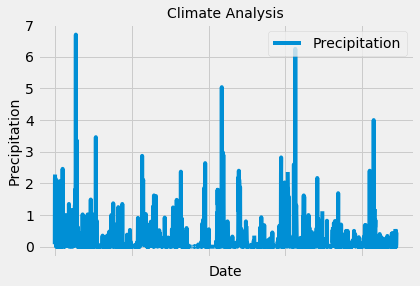

In [189]:
# Use Pandas Plotting with Matplotlib to plot the data
df.plot()
plt.xlabel('Date',fontsize=14)
plt.ylabel('Precipitation',fontsize=14)
plt.title('Climate Analysis',fontsize=14)
plt.legend(['Precipitation'],loc='upper right')

In [19]:
# Display summary statistics for the precipitation data
df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [20]:
# Taking a look at the data provided
first_row = session.query(Station).limit(25).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x16b5c294470>,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1}

In [21]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9)]

In [22]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Station.station,func.count(Measurement.tobs)).\
    filter(Station.station == Measurement.station).\
    group_by(Station.station).\
    order_by(func.count(Measurement.tobs).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [23]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
sel = [func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]

session.query(*sel).\
    filter(Station.station == Measurement.station).\
    filter(Station.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

In [176]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station.
sel = [Measurement.station,
       Measurement.date,
       Measurement.tobs]

q = session.query(*sel).\
    filter(Station.station == Measurement.station).\
    filter(Station.station == 'USC00519281').\
    filter(Measurement.date > yr_ago).\
    order_by(Measurement.date).all()

In [177]:
# Save the sorted query results as a Pandas DataFrame
df = pd.DataFrame(q)
df.head()

,station,date,tobs
0,USC00519281,2016-08-24,77.0
1,USC00519281,2016-08-25,80.0
2,USC00519281,2016-08-26,80.0
3,USC00519281,2016-08-27,75.0
4,USC00519281,2016-08-28,73.0


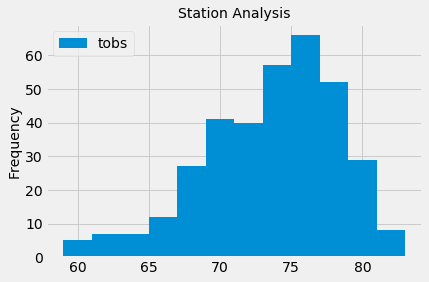

In [179]:
# Use Pandas Plotting with Matplotlib to plot the data as histogram
df.hist(bins=12)
plt.ylabel('Frequency',fontsize=14)
plt.title('Station Analysis',fontsize=14)
plt.legend(['tobs'],loc='upper left')

## Temperature Analysis (Optional)

In [27]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [191]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start = '2017-02-01'
trip_end = '2017-02-13'
trip = calc_temps(trip_start,trip_end)
print(trip[0])

(59.0, 68.83529411764705, 80.0)


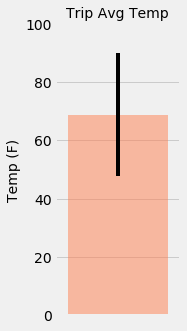

In [174]:
#### Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(2,5))
plt.bar(1,trip[0][1],color='coral',alpha=0.5)
plt.errorbar(1,trip[0][1],yerr=trip[0][2]-trip[0][0],color='k')
plt.title('Trip Avg Temp',fontsize=14)
plt.ylabel('Temp (F)',fontsize=14)
plt.xticks([])
plt.ylim(0,100)
plt.xlim(.5,1.5)
plt.show()

## Other Recommended Analysis (Optional)

In [196]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Station.station,
       Station.name,
       func.sum(Measurement.prcp),
       Station.latitude,
       Station.longitude,
       Station.elevation]

q = session.query(*sel).\
    filter(Station.station == Measurement.station).\
    filter(Measurement.date >= trip_start).\
    filter(Measurement.date <= trip_end).\
    group_by(Station.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()

In [197]:
df = pd.DataFrame(q,columns=['station','name','sum','lat','lon','ele'])
df.head()

,station,name,sum,lat,lon,ele
0,USC00513117,"KANEOHE 838.1, HI US",7.31,21.42340,-157.80150,14.6
1,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",6.91,21.33556,-157.71139,19.5
2,USC00519281,"WAIHEE 837.5, HI US",6.22,21.45167,-157.84889,32.9
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",5.24,21.52130,-157.83740,7.0
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",4.35,21.33310,-157.80250,152.4


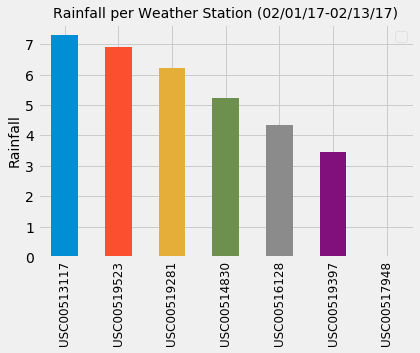

In [165]:
df.plot.bar(x='station',y='sum')
plt.title('Rainfall per Weather Station (02/01/17-02/13/17)',fontsize=14)
plt.xlabel('')
plt.xticks(rotation=90,fontsize=12)
plt.ylabel('Rainfall',fontsize=14)
plt.legend([])

In [190]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


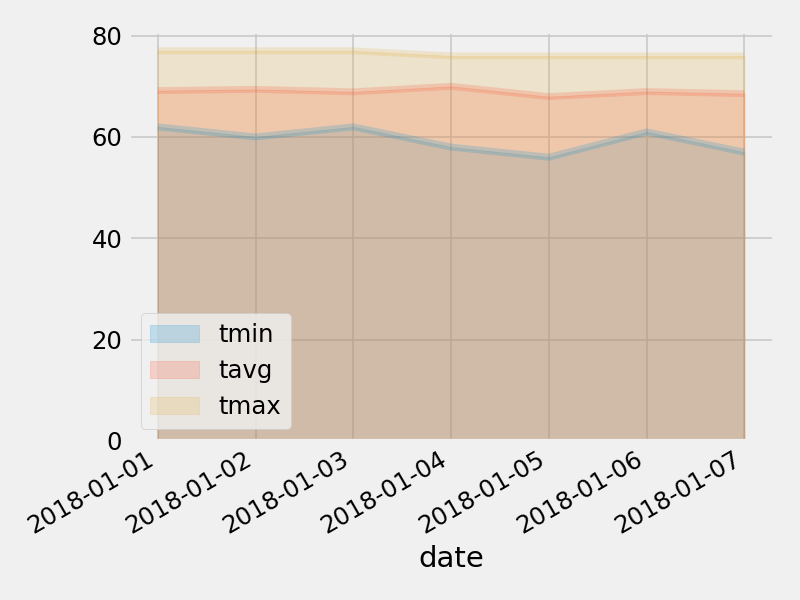

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
